In [13]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import LabelEncoder
import numpy as np
from data_work import data_split
from data_work import processed
from data_work import analyse_dataset
from data_work import set_data
from sklearn.model_selection import train_test_split
import pandas as pd
data=pd.read_csv("/Users/mac/Dev/2022_SE03/data/lasted_data.csv",index_col=None)
data=data.drop("Unnamed: 0",axis=1)

In [14]:

traindata,test_data=train_test_split(data,test_size=0.4,random_state=42,stratify=data['subcategory '])
data = traindata.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)
client_data,server_data=train_test_split(traindata,test_size=0.001,random_state=42)
client_data = client_data.reset_index(drop=True)
server_data = server_data.reset_index(drop=True)

In [15]:
trainloaders,testloaders=data_split(client_data,"subcategory ",8,0.1,IID=1)

prepairing IID dataset
len of client data :4210, len of each subdata : 526
client number 1 : train(474), val(52)
client number 2 : train(474), val(52)
client number 3 : train(474), val(52)
client number 4 : train(474), val(52)
client number 5 : train(474), val(52)
client number 6 : train(474), val(52)
client number 7 : train(474), val(52)
client number 8 : train(474), val(52)


In [16]:
import torch
for i in range(len(trainloaders)):
    trainloaders[i]=torch.tensor(trainloaders[i].values)

In [17]:
from model import Net
from CGan import CGAN
class Argument():
    def __init__(self,data):
        self.noise_size=5
        self.n_features=28
        self.n_classes=8
        self.epoch=10
        self.batch_size=32
        self.dataset=data #tensor
        self.lrG=0.003
        self.lrD=0.003 

In [18]:
class client():
    def __init__(self,cid):
       self.cid=cid
       self.trainset=trainloaders[self.cid] #tensor
       self.testset=testloaders[self.cid] #tensor
       self.labels = torch.unique(self.trainset[:,:1].squeeze())
       args=Argument(self.trainset) #customs

       self.Gan=CGAN(args)
       self.model=Net(0.00)
       
    def update_model(self,params):
        self.model.load_parameters(params)
    def update_Gan(self,params):
        self.Gan.load_parameters(params)
    def Gan_fit(self,data):
        self.Gan.train(data)
        #code Generator fit data
    def model_fit(self,data):
        if len(data)!=0:
            X=data[:,1:].float()
            y=data[:,:1]
            y=y.squeeze().tolist()
            y=torch.tensor(y).long()
        else:
            X=self.trainset[:,1:].float()
            y=self.trainset[:,:1]
            y=y.squeeze().tolist()
            y=torch.tensor(y).long()
        self.model.fit(X,y,0.003,0.2,10)
        #model classify fit
    def get_parameters(self):
        D_parameters,G_parameters=self.Gan.get_parameters()
        M_parameters=self.model.get_parameters()
        return M_parameters,D_parameters, G_parameters
    def evaluate(self):
        X=self.testset[:,1:].float()
        y=self.testset[:,:1]
        y=y.squeeze().tolist()
        y=torch.tensor(y).ft()
        accuracy=self.model.evaluate(X,y)
        return accuracy

In [19]:
def fn_client(cid)->client:
    return client(cid)



In [20]:
class server():
    def __init__(self):
       self.trainset=torch.tensor(server_data.values) #tensor
       self.testset=torch.tensor(test_data.values) #tensor
       args=Argument(self.trainset) #customs

       self.Gan=CGAN(args)
       self.model=Net(0.00)
       
    def update_model(self,params):
        self.model.load_parameters(params)
    def update_Gan(self,params):
        self.Gan.load_parameters(params)
    def Gan_freedata_fit(self):
        self.Gan.freedata_train(self.model)
        #code Generator fit data
    def model_fit(self,data):
        if len(data)!=0:
            X=data[:,1:].float()
            y=data[:,:1]
            y=y.squeeze().tolist()
            y=torch.tensor(y).long()
        else:
            X=self.trainset[:,1:].float()
            y=self.trainset[:,:1]
            y=y.squeeze().tolist()
            y=torch.tensor(y).long()
        self.model.fit(X,y,0.003,0.2,10)
    def get_parameters(self):
        D_parameters,G_parameters=self.Gan.get_parameters()
        M_parameters=self.model.get_parameters()
        return M_parameters,D_parameters, G_parameters
    def evaluate(self):
        X=self.testset[:,1:].float()
        y=self.testset[:,:1]
        y=y.squeeze().tolist()
        y=torch.tensor(y).long()
        accuracy=self.model.evaluate(X,y)
        return accuracy
    def Gen_fake(self,n_samples):
        y=torch.randint(0, 8, (n_samples,))
        y=y.squeeze()
        return self.Gan.sample(y,n_samples)


In [25]:
class Federated_Learning():
    def __init__(self):
        self.server=server()
        self.testset=torch.tensor(test_data.values)
        self.clients=[]
        self.n_clients=8
        for i in range(self.n_clients):
            cl=fn_client(i)
            self.clients.append(cl)
    def client_M_update(self):
        M_params=self.server.model.get_parameters()
        for i in range(self.n_clients):
            self.clients[i].update_model(M_params)
    def server_M_update(self):
        params=self.clients[0].model.get_parameters()
        for i in range(len(params)):
            for k in range(1,self.n_clients):
                params[i]=params[i]+self.clients[k].model.get_parameters()[i]
            params[i]=params[i]/self.n_clients
        self.server.update_model(params)
        print("finished AVG model")

        
    def free_data_simulation(self,rounds):
        accuracy_hist=[]
        print(f"initial setup for free data training")
        self.server.model_fit([])
        loss,accuracy=self.server.evaluate()
        print(f"initial server model, accuracy: {accuracy}, loss: {loss}")
        total_syntheticdata=self.server.trainset
        for round in range(rounds):
            self.server.Gan_freedata_fit()
            f=self.server.Gen_fake(round*100)
            total_syntheticdata=torch.cat((total_syntheticdata,f),dim=0).detach()
            print(f"-------------ready for round {round}-------------")
            self.client_M_update()
            round_fake_data=f
            round_fake_data.detach()
            print(f"complete to update client's M model")
            for i in range(self.n_clients):
                fit_data=torch.cat((self.clients[i].trainset,round_fake_data),dim=0)
                print(f"processing client {i}")
                fit_data=fit_data.detach()
                self.clients[i].model_fit(fit_data)
            self.server_M_update()
            loss,accuracy=self.server.evaluate()
            accuracy_hist.append(accuracy)
            print(f"round {round} accuracy for server: {accuracy}")

        loss,accuracy=self.server.evaluate()
        print(f"----------last accuracy {accuracy} ----------")
        return accuracy_hist
    
        

 
                

In [26]:
ser=Federated_Learning()
acc=ser.free_data_simulation(15)

initial setup for free data training
accuracy of epoch 0 is 0.0
accuracy of epoch 1 is 0.0
accuracy of epoch 2 is 1.0
accuracy of epoch 3 is 1.0
accuracy of epoch 4 is 1.0
accuracy of epoch 5 is 1.0
accuracy of epoch 6 is 1.0
accuracy of epoch 7 is 1.0
accuracy of epoch 8 is 1.0
accuracy of epoch 9 is 1.0
initial server model, accuracy: 0.3472073995019566, loss: 103.75799560546875
training start!!
epoch 0 G loss : 2.068680763244629
epoch 1 G loss : 2.0594961643218994
epoch 2 G loss : 1.9797300100326538
epoch 3 G loss : 2.058943271636963
epoch 4 G loss : 1.9643042087554932
epoch 5 G loss : 1.9737054109573364
epoch 6 G loss : 1.960476279258728
epoch 7 G loss : 1.9295753240585327
epoch 8 G loss : 1.9743951559066772
epoch 9 G loss : 1.9704227447509766
-------------ready for round 0-------------
complete to update client's M model
processing client 0
accuracy of epoch 0 is 0.3368421052631579
accuracy of epoch 1 is 0.37894736842105264
accuracy of epoch 2 is 0.09473684210526316
accuracy of ep

In [23]:
print(acc)


[0.6574172892209178, 0.5631447883315546, 0.5969405905371754, 0.6695126289576663, 0.5414443258626823, 0.6197082888651725, 0.6752045535396656, 0.39950195659907506, 0.3365350409107079, 0.3297758804695838, 0.33938100320170755, 0.3432942013518321, 0.3432942013518321, 0.3685521166844539, 0.39381003201707576]


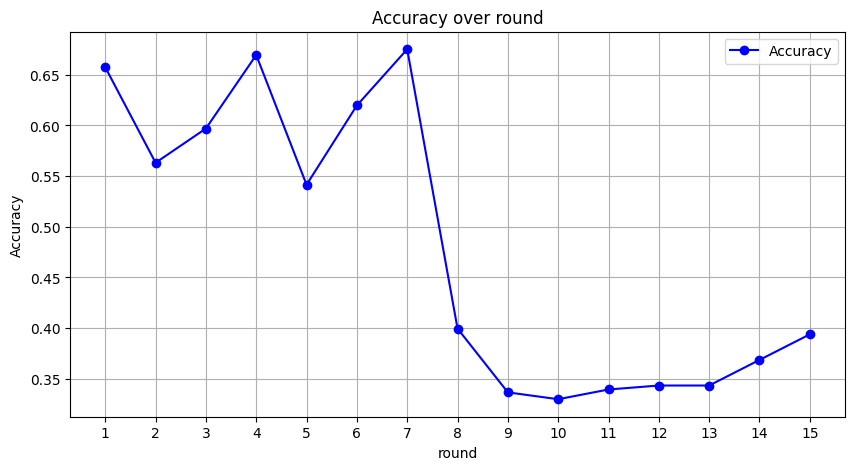

In [24]:
import matplotlib.pyplot as plt

# Danh sách accuracies qua mỗi epoch

# Tạo danh sách các epoch tương ứng
epochs = list(range(1, len(acc) + 1))

# Vẽ đồ thị
plt.figure(figsize=(10, 5))  # Thiết lập kích thước đồ thị
plt.plot(epochs, acc, marker='o', linestyle='-', color='b', label='Accuracy')
plt.title('Accuracy over round')  # Tiêu đề đồ thị
plt.xlabel('round')  # Nhãn trục X
plt.ylabel('Accuracy')  # Nhãn trục Y
plt.xticks(epochs)  # Đánh dấu trục x với các epoch
plt.legend()  # Thêm chú thích
plt.grid(True)  # Thêm lưới
plt.show()  # Hiển thị đồ thị
